## 多目的ベイズ最適化の対話型実行・チュートリアル

目的関数や制約関数を自動的に評価できない場合に、対話型（手作業）で多目的ベイズ最適化を実行するためのnotebookです。下記のような用途を想定しています。  
* 関数評価に数値流体力学(CFD)や有限要素解析(FEA)などを使用しており、形状変更や計算格子の生成を手動で行う必要がある場合
* 数値シミュレーションが利用できず、関数評価に実験室などでの計測が必要である場合
* プログラミングをせずにベイズ最適化を試してみたい場合

Copyright (c) 2022 Nobuo Namura  
This code is released under the MIT License, see LICENSE.txt.  

多目的ベイズ最適化では、下記の論文の手法を用いています。このコードを用いた結果を論文等で公開する場合は、これらを引用ください。

* [N. Namura, "Surrogate-Assisted Reference Vector Adaptation to Various Pareto Front Shapes for Many-Objective Bayesian Optimization," IEEE Congress on Evolutionary Computation, Krakow, Poland, pp.901-908, 2021.](https://doi.org/10.1109/CEC45853.2021.9504917)
* [N. Namura, K. Shimoyama, and S. Obayashi, "Expected Improvement of Penalty-based Boundary Intersection for Expensive Multiobjective Optimization," IEEE Transactions on Evolutionary Computation, vol. 21, no. 6, pp. 898-913, 2017.](https://doi.org/10.1109/TEVC.2017.2693320)

### 0. Import
requirement.txt に記載のライブラリ群をインストール（"pip install -r requirements.txt"）してから、下記のセルを実行（Shift + Enter）してください。

In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import shutil
from bo import BayesianOptimization
import test_problem

### 1. 設定

#### 最適化問題定義  
下記をそのまま実行するとチュートリアル用のデータを読み込みます。  
ご自身の問題に多目的ベイズ最適化を適用する場合は、以下の2つファイルと同様の形式でcsvファイルを作成し、下記セルのファイル名を作成したファイルに合わせてください。  
* design_space_sgm.csv: 設計変数の定義域（最小値、最大値）を指定するファイル。  
* sample_sgm.csv: ガウス過程モデルの学習データを記載したファイル。行方向に各学習データ、列方向に設計変数（$x1, x2, ...$）、目的関数（$f1, f2, ...$）、制約関数（$g1, g2, ...$）を入力。制約条件がない場合、制約関数は省略可能  

制約関数は、$g(x) <= 0$ の形に式変形した値を入力してください。  
例：ある場所の応力 $\sigma(x)$ が、ある値 $c$ 以下に制約したい場合、$\sigma(x) \leqq c$ を変形して、$\sigma(x) - c \leqq 0$ とし、$g(x) = \sigma(x) - c$ の数値をファイルに入力してください。

In [2]:
# ここを編集 -----------------------------------------------------------------
f_design_space = 'design_space_sgm.csv'        # 設計変数の定義域を指定するファイルの名前
f_sample = 'sample_sgm.csv'                    # 学習データを記載したファイルの名前
n_add = 5                                      # ベイズ最適化で生成する解候補の数
# ----------------------------------------------------------------------------

# ファイル読み込み
df_design_space = pd.read_csv(f_design_space)
df_sample = pd.read_csv(f_sample)
nf = df_sample.columns.str.contains('f').sum() # 目的関数の数を読み込み
ng = df_sample.columns.str.contains('g').sum() # 制約関数の数を読み込み

# 最大化すべき目的関数がある場合や、関数にノイズが含まれる場合は以下を修正 ---
MIN = np.full(nf, True)                        # 各目的関数に対して、「True=最小化, False=最大化」を配列で指定
NOISE = np.full(nf+ng, False)                  # 各目的関数、制約関数に対して、「True=ノイズあり, False=ノイズなし」を配列で指定
# ----------------------------------------------------------------------------

#### パラメータ設定  
下記のパラメータを調整することで、より高度な最適化が可能です。進化計算や多目的最適化について詳しくない場合、下記の推奨値をそのまま利用ください。

In [3]:
division = pd.read_csv('reference_vector_division.csv', index_col=0)
CRITERIA = 'EPBII'                             # 多目的ベイズ最適化の獲得関数を選択：EPBII or EIPBII
SRVA = True                                    # 上記の獲得関数で用いる参照ベクトルの生成方法：True=surrogate-assisted reference vector adaptation, False=two-layered simplex latice-design
OPTIMIZER = 'NSGA3'                            # ガウス過程モデル上での多目的最適化に用いるアルゴリズム：NSGA3 or NSGA2
# 獲得関数で用いる参照ベクトルの数
n_randvec = division.loc[nf, 'npop']           # SRVA=Trueの場合は適応型ベクトルの数、SRVA=Falseの場合はランダムベクトルの数 (>=0)
nh = 0 #division.loc[nf, 'nh']                 # SRVA=Falseの場合、Two-layered simplex latice-design で用いる外側層の分割数 (>=0)
nhin = 0 #division.loc[nf, 'nhin']             # SRVA=Falseの場合、Two-layered simplex latice-design で用いる内側層の分割数 (>=0)
# 多目的最適化に用いるアルゴリズムのパラメータ
ngen_ea = 200                                  # 世代数
npop_ea = division.loc[nf, 'npop_ea']          # OPTIMIZER='NSGA2'の場合の個体数
nh_ea = division.loc[nf, 'nh_ea']              # OPTIMIZER='NSGA3'の場合、NSGA3で用いるTwo-layered simplex latice-design で用いる外側層の分割数 (>=0)
nhin_ea = division.loc[nf, 'nhin_ea']          # OPTIMIZER='NSGA3'の場合、NSGA3で用いるTwo-layered simplex latice-design で用いる内側層の分割数 (>=0)

### 2. 初期化

In [4]:
gp = BayesianOptimization(df_sample, df_design_space, MIN)

### 3. ガウス過程モデルの学習  
遺伝的アルゴリズム(GA)を用いて、尤度が最大となるようにハイパーパラメータを決定します。
* theta0: ハイパーパラメータの上限値、$10^{theta0}$ が上限値になります
* npop: GAの個体数
* ngen: GAの最大世代数
* mingen: GAの最小世代数
* STOP: Trueの場合、mingen以上の世代数で収束判定を行い、収束した場合にはngenに至る前に最適化を打ち切ります
* PRINT: Trueの場合、GAでの最適化履歴を出力します
* theta: 最適化によって得られたハイパーパラメータ (出力)

In [5]:
warnings.simplefilter('ignore')
theta = gp.training(theta0 = 3.0, npop = 500, ngen = 500, mingen=0, STOP=True, NOISE=NOISE, PRINT=False)
gp.construction(theta)

--- 1-th function estimation -------------------
--- 2-th function estimation -------------------
--- 3-th function estimation -------------------


### 4. 解候補の生成  
MOEA/Dという進化計算アルゴリズムを用いて獲得関数を最大化し、次に目的関数、制約関数を評価すべき解候補を生成します。  
※下記に出力される目的関数（$f1, f2, ...$）と制約関数（$g1, g2, ...$）の値は、ガウス過程モデルによる予測値です。

In [6]:
x_add, f_add_est, g_add_est = gp.optimize_multiobjective_problem(CRITERIA=CRITERIA, OPTIMIZER=OPTIMIZER, SRVA=SRVA, n_add=n_add, n_randvec=n_randvec, nh_ea=nh_ea, nhin_ea=nhin_ea, npop_ea=npop_ea, ngen_ea=ngen_ea, PLOT=False, PRINT=False)
add_sample = pd.DataFrame(np.hstack([x_add, f_add_est, g_add_est]), columns=np.hstack(['x'+np.arange(1,1+gp.nx).astype(str).astype(object), 'f'+np.arange(1,1+gp.nf).astype(str).astype(object), 'g'+np.arange(1,1+gp.ng).astype(str).astype(object)]))
add_sample

Multi-objective optimization on the Kriging models
Single objective optimization for the 1-th objective function
Single objective optimization for the 2-th objective function
EPBII maximization with MOEA/D


,x1,x2,f1,f2,g1
0,0.873419,0.837911,0.137376,-0.559250,-0.041150
1,0.623558,0.249906,-0.142612,-0.125093,-0.063592
2,0.495775,0.207801,-0.010130,-0.320692,-0.123074
3,0.415360,0.163963,0.084480,-0.393950,-0.170324
4,0.536953,0.229161,-0.066584,-0.256516,-0.099244


### 5. 可視化 (目的関数が2または3個の場合のみ)

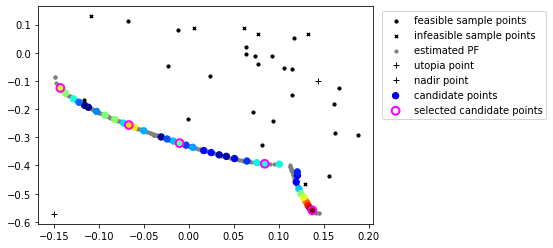

In [7]:
#%matplotlib notebook
rank = gp.pareto_ranking(gp.f, gp.g)
feasible = ~np.any(gp.g>0, axis=1)
if gp.nf == 2:
    plt.figure('2D Objective-space with '+str(gp.ns)+'-samples')
    plt.scatter(gp.f[feasible,0], gp.f[feasible,1], marker='o', c='black', s=10, label='feasible sample points')
    plt.scatter(gp.f[~feasible,0], gp.f[~feasible,1], marker='x', c='black', s=10, label='infeasible sample points')
    plt.scatter(gp.f_opt[:,0], gp.f_opt[:,1], marker='o', c='grey', s=10, label='estimated PF')
    plt.plot(gp.utopia[0], gp.utopia[1], '+', c='black', label='utopia point')
    plt.plot(gp.nadir[0], gp.nadir[1], '+', c='black', label='nadir point')
    plt.scatter(gp.f_candidate[:,0], gp.f_candidate[:,1], c=gp.fitness_org, cmap='jet', marker='o', s=40, label='candidate points')
    plt.scatter(f_add_est[:,0],f_add_est[:,1], facecolors='none', edgecolors='magenta', marker='o', s=60, linewidth=2, label='selected candidate points')
    plt.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left')
elif gp.nf == 3:
    fig = plt.figure('3D Objective-space with '+str(gp.ns)+'-samples')
    ax = Axes3D(fig)
    # ax.scatter3D(gp.f[rank>1,0], gp.f[rank>1,1], gp.f[rank>1,2], marker='o', c='black', s=10, label='sample points')
    # ax.scatter3D(gp.f_opt[:,0], gp.f_opt[:,1], gp.f_opt[:,2], marker='o', c='grey', s=10, alpha=0.5, label='estimated PF')
    ax.scatter3D(gp.f[rank==1,0], gp.f[rank==1,1], gp.f[rank==1,2], marker='o', c='blue', s=20, label='NDSs among sample points')
    ax.scatter3D(gp.f_candidate[:,0], gp.f_candidate[:,1], gp.f_candidate[:,2], c=gp.fitness_org, cmap='jet', marker='*', s=40, label='candidate points')
    ax.scatter3D(f_add_est[:,0], f_add_est[:,1], f_add_est[:,-1], marker='o', c='none', edgecolor='magenta', s=60, linewidth=2, label='selected candidate points')
    ax.view_init(elev=30, azim=45)
    plt.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left')

### 6. ファイル書き出し
* 生成されたファイルの設計変数に対する目的関数、制約関数の値を、実際に評価・入力してファイルを上書き保存してください
* "1. 設定" に戻り、"f_sample"のファイル名を上書き保存したファイル名に変更して、これまでの操作を繰り返します（納得できる解が得られたらベイズ最適化を終了します）

In [8]:
path, extension = os.path.splitext(f_sample)
f_sample_out =  path + '_' + str(gp.ns+n_add) + extension
shutil.copyfile(f_sample, f_sample_out)
with open(f_sample_out, 'a') as file:
    np.savetxt(file, x_add, delimiter=',')

### おまけ: チュートリアル用データ"sample_sgm.csv"の目的・制約関数評価
* f_sampleにsample_sgm.csvを用いている場合、以下を実行すると解候補の目的関数、制約関数の値を評価し、ファイルに出力します
* **main.py**を使うと、この操作を自動的に実行できます。 

In [9]:
f_add = np.array([test_problem.SGM(x_add[i,:], nf=2, ng=1, seed=3) for i in range(n_add)])
path, extension = os.path.splitext(f_sample)
f_sample_sgm =  path + '_' + str(gp.ns+n_add) + '_evaluated' + extension
shutil.copyfile(f_sample, f_sample_sgm)
with open(f_sample_sgm, 'a') as file:
    np.savetxt(file, np.hstack([x_add, f_add]), delimiter=',')